In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/moviedatasets/ratings.csv
/kaggle/input/moviedatasets/links_small.csv
/kaggle/input/moviedatasets/credits.csv
/kaggle/input/moviedatasets/keywords.csv
/kaggle/input/moviedatasets/movies_metadata.csv
/kaggle/input/moviedatasets/ratings_small.csv
/kaggle/input/moviedatasets/links.csv


# Step 1: Data Collection and Preprocessing

In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
import string # for string manipulation operations
import re # for regular expression operations n. 

import pandas as pd #for data manipulation and analysis
import numpy as np #for numerical computing
import seaborn as sns #for data visualization
import matplotlib.pyplot as plt #for data visualization
import tensorflow as tf #for building and training deep learning models
import tensorflow_recommenders as tfrs #as a high-level API for building recommendation models on top of TensorFlow
from collections import Counter #for counting occurrences of elements in a list or other iterable
from typing import Dict, Text #for declaring data types in a function or module
from ast import literal_eval #for evaluating strings as code
from datetime import datetime #for working with dates and times
from wordcloud import WordCloud #for generating word clouds from text
from sklearn.preprocessing import MinMaxScaler #for feature scaling
from sklearn.feature_extraction.text import TfidfVectorizer #for converting text into numerical features
from sklearn.metrics.pairwise import cosine_similarity #for measuring similarity between two non-zero vectors of an inner product space.
import random #To generate random numbers to select random movies for user to rate

import warnings
warnings.filterwarnings('ignore')

2024-05-28 05:37:48.682274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 05:37:48.682389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 05:37:48.810778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
credits = pd.read_csv('/kaggle/input/moviedatasets/credits.csv')
keywords = pd.read_csv('/kaggle/input/moviedatasets/keywords.csv')
movies = pd.read_csv('/kaggle/input/moviedatasets/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

#Fill in the missing values
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [6]:
#A function to extract the useful information from the columns
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

#Applying the functions to the columns 
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [7]:
#Changing the datatype of certain columns
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [8]:
#Here, I am choosing movies released after 2009 and which were originally shot in English
df = df[df['release_date'].dt.year>2009]
df = df[df['original_language']=='en']
df = df.reset_index()

In [9]:
# Cleaned dataset
df.head()

,index,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,854,False,0.0,"Drama, Romance",79782,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.147130,,...,0.0,110.0,Polski,,7.5,4.0,,"Jan Jakub Kolski, Artur Reinhart, Witold Chomi...","Marek, Joanna - Marek's mother, Roman - Marek'...","Marcin Walewski, Magdalena Cielecka, Mariusz B..."
1,1063,False,0.0,"Comedy, Horror",141210,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,,...,0.0,6.0,,,8.0,1.0,,Chris Cullari,"Rachel, Eric, Rachel, Mrs. Roberts, The Slasher","Josh Feldman, Gus Kamp, Carolyn Jania, Kristin..."
2,2086,False,0.0,Drama,143750,en,The Farmer's Wife,"As her surroundings are invaded by outsiders, ...",0.211754,,...,0.0,18.0,English,,10.0,1.0,short,"John Parish, Jonas Grimås, Gary Shaw, Francis ...","The Auctioneer, The Farmer's Wife, Denise, Man","James Cartwright, Geraldine James, Alex Kelly,..."
3,2521,False,0.0,Documentary,84198,en,A Place at the Table,"Using personal stories, this powerful document...",0.501046,,...,0.0,84.0,English,One Nation. Underfed.,6.9,7.0,woman director,"Kristi Jacobson, Lori Silverbush","Himself, Himself, Herself, Himself, Herself, H...","Jeff Bridges, Tom Colicchio, Mariana Chilton, ..."
4,2731,False,0.0,"Romance, Drama, Comedy",171982,en,Romance,She's as hot as Britney Spears. Hotter. She pa...,0.052377,,...,0.0,27.0,English,,0.0,0.0,,"Chuck Palahniuk, Andy Mingo, Andy Mingo","John, Brit, Mother, Friend #1, Mother's Boyfri...","Brian Allard, Amber Arrigotti, Robynn Hayek, R..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8243 entries, 0 to 8242
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 8243 non-null   int64         
 1   adult                 8243 non-null   object        
 2   budget                8243 non-null   float64       
 3   genres                8243 non-null   object        
 4   id                    8243 non-null   int64         
 5   original_language     8243 non-null   object        
 6   original_title        8243 non-null   object        
 7   overview              8243 non-null   object        
 8   popularity            8243 non-null   float64       
 9   production_companies  8243 non-null   object        
 10  production_countries  8243 non-null   object        
 11  release_date          8243 non-null   datetime64[ns]
 12  revenue               8243 non-null   float64       
 13  runtime           

In [11]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

# Vis 1 

(-1.25, 1.25, -1.25, 1.25)

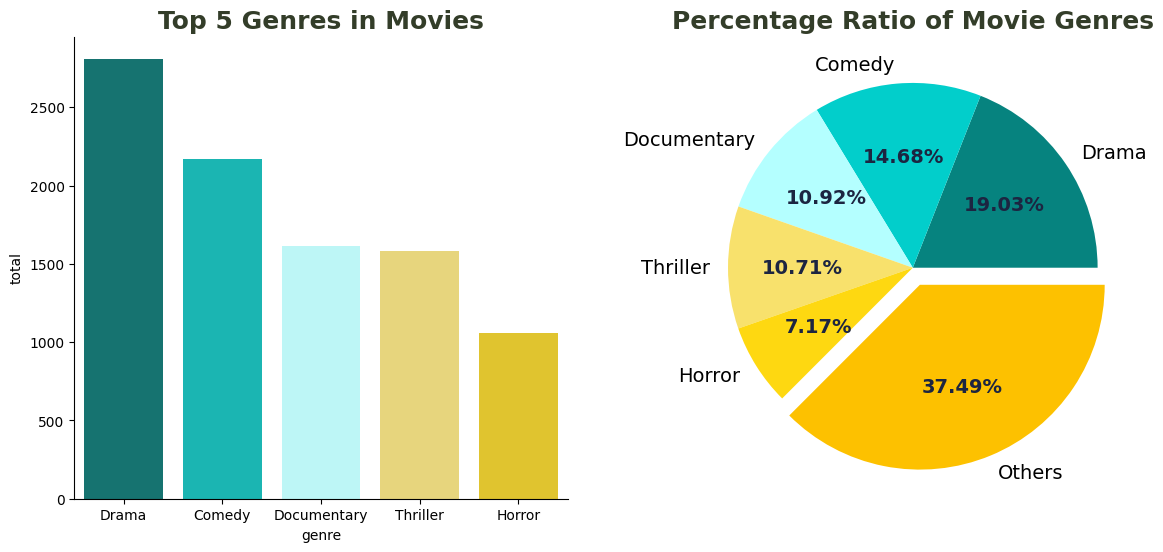

In [12]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

# Vis 2

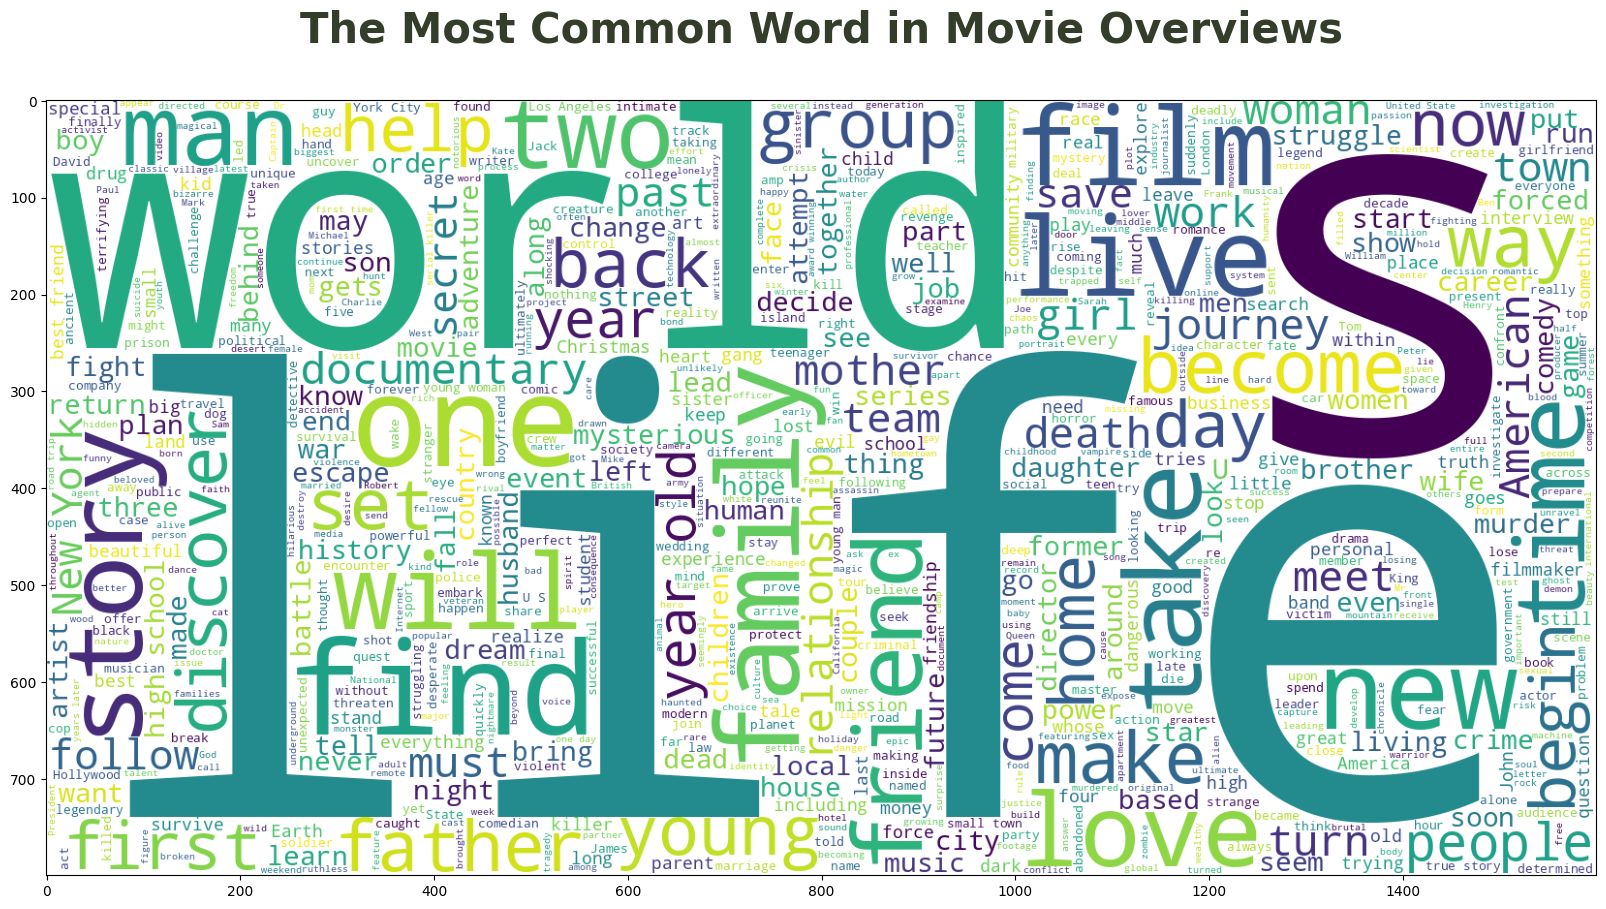

In [13]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

In [14]:
#Importing the dataset of the ratings
ratings_df = pd.read_csv('/kaggle/input/moviedatasets/ratings.csv')

In [15]:
#Changing the datatype of the 'date' column
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

#Adding the columns from the merged dataset
ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)
ratings_df.head()


,userId,movieId,rating,date,original_title,genres,overview
0,7,88744,1.5,2017-02-05 00:19:34,Die Frau mit den 5 Elefanten,"Documentary, Foreign","Documentary about Svetlana Geier, a Ukranian w..."
1,11,47518,3.0,2009-01-11 12:08:08,The Tortured,Horror,An upper-middle-class couple's life is destroy...
2,11,49530,3.5,2009-01-11 12:24:52,In Time,"Action, Thriller, Science Fiction",In the not-too-distant future the aging gene h...
3,11,50601,2.5,2009-01-11 13:02:10,5 Days of War,"War, Drama",An American journalist and his cameraman are c...
4,11,51540,4.0,2009-01-11 12:21:47,Horrible Bosses,"Comedy, Crime","For Nick, Kurt and Dale, the only thing that w..."


In [16]:
#Selecting the id and title column of the merged dataframe
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,79782,Wenecja
1,141210,The Sleepover
2,143750,The Farmer's Wife
3,84198,A Place at the Table
4,171982,Romance


In [17]:
#Selecting the UserId, title, and rating from the ratings dataframe
ratings_df = ratings_df[['userId', 'original_title', 'rating']]
ratings_df.head()

,userId,original_title,rating
0,7,Die Frau mit den 5 Elefanten,1.5
1,11,The Tortured,3.0
2,11,In Time,3.5
3,11,5 Days of War,2.5
4,11,Horrible Bosses,4.0


In [18]:
#Resetting the index of the movies dataframe
movies_df = movies_df.reset_index()
movies_df.head()

,index,movieId,original_title
0,0,79782,Wenecja
1,1,141210,The Sleepover
2,2,143750,The Farmer's Wife
3,3,84198,A Place at the Table
4,4,171982,Romance


In [19]:
#Resetting the index of the merged dataframe
df = df.reset_index()
df.head()
del df['level_0']

In [20]:
#Sorting by popularity to let the user rate the most popular ones
pdf = df.sort_values('popularity', ascending=False)
pdf = pdf.reset_index()
pdf.head()

,level_0,index,adult,budget,genres,id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,4194,28982,False,74000000.0,"Family, Animation, Adventure, Comedy",211672,en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,...,1.156731e+09,91.0,English,"Before Gru, they had a history of bad bosses",6.4,4729.0,"assistant, aftercreditsstinger, duringcreditss...","Christopher Meledandri, Kyle Balda, Ken Daurio...","Scarlet Overkill (voice), Herb Overkill (voice...","Sandra Bullock, Jon Hamm, Michael Keaton, Alli..."
1,7837,40726,False,34000000.0,"Action, Crime",339403,en,Baby Driver,After being coerced into working for a crime b...,228.032744,...,2.245113e+08,113.0,English,All you need is one killer track.,7.2,2083.0,"robbery, atlanta, music, crime boss, romance, ...","Edgar Wright, Edgar Wright, Tim Bevan, James B...","Baby, Deborah, Doc, Bats, Buddy, Darling, Jose...","Ansel Elgort, Lily James, Kevin Spacey, Jamie ..."
2,2752,23304,False,165000000.0,"Adventure, Family, Animation, Action, Comedy",177572,en,Big Hero 6,The special bond that develops between plus-si...,213.849907,...,6.521054e+08,102.0,English,From the creators of Wreck-it Ralph and Frozen,7.8,6289.0,"brother brother relationship, hero, talent, re...","John Lasseter, Robert Richardson, Mark Henley,...","Baymax (voice), Hiro Hamada (voice), Tadashi H...","Scott Adsit, Ryan Potter, Daniel Henney, T.J. ..."
3,3270,25206,False,58000000.0,"Action, Adventure, Comedy",293660,en,Deadpool,Deadpool tells the origin story of former Spec...,187.860492,...,7.831130e+08,108.0,English,Witness the beginning of a happy ending,7.4,11444.0,"anti hero, mercenary, marvel comic, superhero,...","Robert Alonzo, Tim Miller, Rhett Reese, Paul W...","Wade Wilson / Deadpool, Vanessa Carlysle / Cop...","Ryan Reynolds, Morena Baccarin, Ed Skrein, T.J..."
4,3272,25208,False,200000000.0,"Action, Adventure, Comedy, Science Fiction",283995,en,Guardians of the Galaxy Vol. 2,The Guardians must fight to keep their newfoun...,185.330992,...,8.634161e+08,137.0,English,Obviously.,7.6,4858.0,"sequel, superhero, based on comic, misfit, spa...","Lisa J. Levine, Jason C. Lewis, Lora Hirschber...","Peter Quill / Star-Lord, Gamora, Drax the Dest...","Chris Pratt, Zoe Saldana, Dave Bautista, Vin D..."


In [23]:
#Random number generation for the user to rate movies out of 5
user_id = 270897
m = 3
randomList = []
for i in range(10):
    r=random.randint(1,10)
    if r not in randomList:
        randomList.append(r)
        
print("Welcome")
name = input("Enter your name:")
for i in randomList:
    movie = pdf['original_title'][i]
    print(i)
    
    movie_row = pdf[pdf['original_title'] == movie]
    print()
    print(movie)
    print("Overview: ", pdf[pdf['original_title'] == movie]['overview'][i])
    print("Cast: ", pdf[pdf['original_title'] == movie]['actors'][i])
    user_r = input('Enter your rating out of 5 (Enter dk if you dont know the movie)')
    if(user_r=='dk'):
        continue;
    else:
        user_r = int(user_r)
        new_row = {'userId':270897, 'original_title':movie, 'rating':user_r}
        ratings_df = ratings_df.append(new_row, ignore_index=True)

Welcome


Enter your name: zehra


9

Captain America: Civil War
Overview:  Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarizes opinion amongst the Avengers, causing two factions to side with Iron Man or Captain America, which causes an epic battle between former allies.
Cast:  Chris Evans, Robert Downey Jr., Scarlett Johansson, Sebastian Stan, Anthony Mackie, Don Cheadle, Jeremy Renner, Chadwick Boseman, Paul Bettany, Elizabeth Olsen, Paul Rudd, Emily VanCamp, Tom Holland, Frank Grillo, William Hurt, Daniel Brühl, Martin Freeman, John Slattery, Marisa Tomei, Hope Davis, John Kani, Kerry Condon, Gene Farber, Florence Kasumba, Alfre Woodard, Jim Rash, Stan Lee, Joe Russo, Damion Poitier, Michael A. Cook, Laughton Parchment, Jackson Spidell, Yi Long, Heidi Moneymaker, Aaron Toney, Cale Schultz, Ann Russo, Cornell John, Sven Hönig, Joshua Peck, Brent McGee, Be Satrazemis, Blair Jasin, Oli Bigalke, Rafael Banasik, David de Vr

Enter your rating out of 5 (Enter dk if you dont know the movie) 5


AttributeError: 'DataFrame' object has no attribute 'append'

# Step 2: Building the Hybrid Neural Network:

In [24]:
#Changing the datatype to string
ratings_df['userId'] = ratings_df['userId'].astype(str)

#Creating data for the model
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [25]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 109485


In [26]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 8243
Unique users: 36332


In [27]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [28]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=10)

Epoch 1/10


I0000 00:00:1716875683.507899     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 13s 2s/step - root_mean_squared_error: 2.7001 - factorized_top_k/top_1_categorical_accuracy: 0.0032 - factorized_top_k/top_5_categorical_accuracy: 0.0291 - factorized_top_k/top_10_categorical_accuracy: 0.0654 - factorized_top_k/top_50_categorical_accuracy: 0.1476 - factorized_top_k/top_100_categorical_accuracy: 0.1701 - loss: 54891.6536 - regularization_loss: 0.0000e+00 - total_loss: 54891.6536
Epoch 2/10
5/5 [==============================] - 9s 2s/step - root_mean_squared_error: 2.0542 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.2032 - factorized_top_k/top_10_categorical_accuracy: 0.3542 - factorized_top_k/top_50_categorical_accuracy: 0.5666 - factorized_top_k/top_100_categorical_accuracy: 0.6055 - loss: 53744.9089 - regularization_loss: 0.0000e+00 - total_loss: 53744.9089
Epoch 3/10
5/5 [==============================] - 8s 2s/step - root_mean_squared_error: 1.0090 - factorized_top_k/to

# Step 3: Training and Evaluating the Model:

In [29]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 3s 830ms/step - root_mean_squared_error: 1.0373 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0267 - factorized_top_k/top_10_categorical_accuracy: 0.0511 - factorized_top_k/top_50_categorical_accuracy: 0.1812 - factorized_top_k/top_100_categorical_accuracy: 0.2727 - loss: 34078.3854 - regularization_loss: 0.0000e+00 - total_loss: 34078.3854

Retrieval top-100 accuracy: 0.273
Ranking RMSE: 1.037


# Step 4: Making Personalized Recommendations:

In [30]:
#A function to recommend movies to the user
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, name))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

#Predict the rating a user will give for a movie        
def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".foxrmat(movie, predicted_rating.numpy()[0][0]))

In [31]:
#Predicting the movies for the users
predict_movie(270897, 5)

Top 5 recommendations for user zehra:

1. Repo Men
2. Imagine
3. Ca$h
4. Brake
5. Acciaio


In [32]:
#Get meta data for recommendations
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

#Store the details of the recommendations in a new datafram
_, titles = index(tf.constant(['270897']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(df[['original_title', 'genres', 'overview', 'actors']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

In [33]:
#Displaying the details of the recommendations
for i in range(1,6):
    print("Details about your recommendations:")
    print("Number: ", i)
    print("Movie: ", pred_df['original_title'][i])
    print("Overview: ", pred_df['overview'][i])
    print("Genres: ", pred_df['genres'][i])
    print("Cast: ", pred_df['actors'][i])
    print()

Details about your recommendations:
Number:  1
Movie:  Repo Men
Overview:  In the future, medical technology has advanced to the point where people can buy artificial organs to extend their lives. But if they default on payments, an organization known as the Union sends agents to repossess the organs. Remy is one of the best agents in the business, but when he becomes the recipient of an artificial heart, he finds himself in the same dire straits as his many victims.
Genres:  Action, Science Fiction, Thriller, Crime
Cast:  Jude Law, Forest Whitaker, Alice Braga, Liev Schreiber, Carice van Houten, Chandler Canterbury, RZA, Joe Pingue, Tiffany Espensen, Liza Lapira, Yvette Nicole Brown, Tanya Clarke, John Leguizamo, Daniel Lévesque, Max Turnbull

Details about your recommendations:
Number:  2
Movie:  Imagine
Overview:  A blind teacher breaks the rules to help a female student rediscover the pleasures of life.
Genres:  Drama
Cast:  Alexandra Maria Lara, Edward Hogg, David Atrakchi, Teresa